In [23]:
import regex
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

def filter_text(text, stop_words):
    word_tokens = WordPunctTokenizer().tokenize(text.lower())
    filtered_text = [regex.sub('[^a-z ]+', '', w) for w in word_tokens]
    filtered_text = [regex.sub('[ ][ ]+', '', w) for w in filtered_text]
    filtered_text = [regex.sub('[0-9]', '', w) for w in filtered_text]
    filtered_text = [wordnet_lemmatizer.lemmatize(w, 'v') for w in filtered_text if not w in stop_words and len(w) > 2 and len(w) < 50]
    return " ".join(filtered_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:

df = pd.read_csv("bugs-train.csv")
df = df[df['severity'] != "trivial"] #not in the given classes
df["filtered_text"] = df["summary"].apply(lambda x : filter_text(x, stop))
df.head()

,bug_id,summary,severity,filtered_text
0,365569,Remove workaround from bug 297227,normal,remove workaround bug
1,365578,Print Preview crashes on any URL in gtk2 builds,critical,print preview crash url gtk build
2,365582,Lines are not showing in table,major,line show table
3,365584,Firefox render ÛÏsimplified ArabicÛ font fa...,normal,firefox render simplify arabic font face incor...
4,365597,Crash [@ nsINodeInfo::NodeInfoManager],critical,crash nsinodeinfo nodeinfomanager


In [25]:

df['classification'] = df['severity'].replace(['enhancement', 'minor', 'normal', 'major', 'blocker','critical'],[1,2,3,4,5,6])
df['classification'] = df['classification'].dropna()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
df['classification'].astype(int)


0         3
1         6
2         4
3         3
4         6
         ..
159993    3
159994    3
159995    6
159996    6
159997    3
Name: classification, Length: 158794, dtype: int64

In [26]:
temp_df, test_df = train_test_split(df, test_size=0.3, random_state = 42, stratify = df['classification'])
train_df, val_df = train_test_split(temp_df, test_size=0.2, random_state = 42, stratify = temp_df['classification'])

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english',  min_df = 2, max_features = 17673, use_idf = True)
x_train = tfidf.fit_transform(train_df['filtered_text'])
x_val = tfidf.transform(val_df['filtered_text'])
y_train = train_df['classification']
y_val = val_df['classification']

x_test = tfidf.transform(test_df['filtered_text'])
y_test = test_df['classification']

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

Training Random Forest

In [29]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [41]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [42]:
y_val_pred = rf_model.predict(x_val)
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy:  0.8570914488776933
Validation Classification Report:
               precision    recall  f1-score   support

           1       0.32      0.05      0.08       620
           2       0.09      0.04      0.05       434
           3       0.88      0.96      0.92     17620
           4       0.64      0.06      0.11       847
           5       0.29      0.04      0.07        98
           6       0.79      0.77      0.78      2612

    accuracy                           0.86     22231
   macro avg       0.50      0.32      0.33     22231
weighted avg       0.82      0.86      0.83     22231



In [43]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

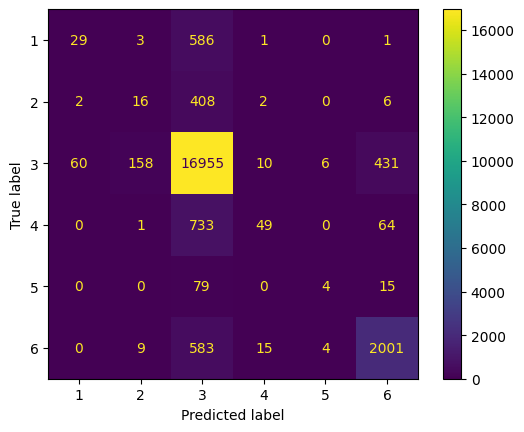

In [44]:
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_model.classes_)
disp.plot()
plt.show()


In [45]:
y_test_pred = rf_model.predict(x_test)
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Test Accuracy:  0.8573227817544449
Test Classification Report:
               precision    recall  f1-score   support

           1       0.26      0.03      0.06      1328
           2       0.08      0.04      0.05       931
           3       0.88      0.96      0.92     37757
           4       0.66      0.06      0.11      1816
           5       0.30      0.03      0.05       210
           6       0.80      0.76      0.78      5597

    accuracy                           0.86     47639
   macro avg       0.50      0.31      0.33     47639
weighted avg       0.82      0.86      0.83     47639



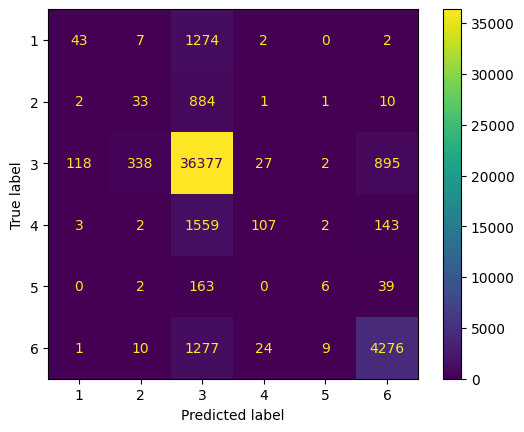

In [46]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_model.classes_)
disp.plot()
plt.show()


In [47]:
pred_df = pd.read_csv("bugs-test.csv")
pred_df['filtered_text'] = pred_df["summary"].apply(lambda x : filter_text(x, stop))




In [48]:
tfidf1 = TfidfVectorizer(stop_words = 'english',  min_df = 2, max_features = 17673, use_idf = True)
x_test = tfidf1.fit_transform(pred_df['filtered_text'])


In [49]:

predictions = rf_model.predict(x_test)

In [50]:
severity_mapping = {'enhancement': 1, 'minor': 2, 'normal': 3, 'major': 4, 'blocker': 5, 'critical': 6}
inverse_severity_mapping = {v: k for k, v in severity_mapping.items()}
predictions_labels = [inverse_severity_mapping[pred] for pred in predictions]


In [51]:
pred_df['prediction'] = predictions
pred_df = pd.DataFrame({
    'bug_id': pred_df['bug_id'],
    'prediction': predictions_labels
})
pred_df.to_csv("predictions_weighted.csv", index=False)

print("Predictions saved to 'predicted_bugs.csv'")

Predictions saved to 'predicted_bugs.csv'
